In [1]:
import sys
import tyssue
import random
import numpy as np
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline
import ipyvolume as ipv
from matplotlib import pyplot


from IPython.display import Image


from tyssue.topology import add_vert


from tyssue import config, Sheet, SheetGeometry, History, EventManager, PlanarGeometry
from tyssue import SheetGeometry as geom
from tyssue import PlanarGeometry as geom
from tyssue.draw.plt_draw import create_gif
from tyssue.draw.plt_draw import plot_forces
from tyssue.draw import sheet_view
from tyssue.dynamics import effectors, model_factory
from tyssue.dynamics import PlanarModel
from tyssue.dynamics import SheetModel as model
from tyssue.generation import three_faces_sheet
from tyssue.solvers.viscous import EulerSolver
from tyssue.solvers.quasistatic import QSSolver
from tyssue.draw import sheet_view
from tyssue.draw.plt_draw import plot_forces
from tyssue.io import hdf5
import copy

from tyssue.geometry.planar_geometry import PlanarGeometry as geom
from tyssue.solvers.quasistatic import QSSolver
from tyssue.dynamics.planar_vertex_model import PlanarModel as model


from tyssue.stores import load_datasets

from tyssue.topology.sheet_topology import remove_face, cell_division

import warnings
warnings.filterwarnings('ignore')

### T1 transitions

from tyssue.topology.sheet_topology import type1_transition
from tyssue.topology.base_topology import collapse_edge, remove_face
from tyssue.topology.sheet_topology import split_vert as sheet_split
from tyssue.topology.bulk_topology import split_vert as bulk_split
from tyssue.topology import condition_4i, condition_4ii

C++ extension are not available for this version
collision solver could not be imported You may need to install CGAL and re-install tyssue


In [2]:
def create_frames(
    history,
    output,
    movie_name,
    num_frames=None,
    interval=None,
    draw_func=None,
    margin=5,
    **draw_kwds,
):
    """Creates a set of png frames of the recorded history.
   
    Parameters
    ----------
    history : a :class:`tyssue.History` object
    output : path to the output directory
    num_frames : int, the number of frames in the gif
    interval : tuples, define begin and end frame of the gif
    draw_func : a drawing function
         this function must take a `sheet` object as first argument
         and return a `fig, ax` pair. Defaults to quick_edge_draw
         (aka sheet_view with quick mode)
    margin : int, the graph margins in percents, default 5
         if margin is -1, let the draw function decide
    **draw_kwds are passed to the drawing function
    """
    if draw_func is None:
        draw_func = sheet_view

    graph_dir = Path(output + '/' + movie_name)
    graph_dir.mkdir(parents=True, exist_ok=True)

    x, y = coords = draw_kwds.get("coords", history.sheet.coords[:2])
    sheet0 = history.retrieve(0)
    bounds = sheet0.vert_df[coords].describe().loc[["min", "max"]]
    delta = (bounds.loc["max"] - bounds.loc["min"]).max()
    margin = delta * margin / 100
    xlim = bounds.loc["min", x] - margin, bounds.loc["max", x] + margin
    ylim = bounds.loc["min", y] - margin, bounds.loc["max", y] + margin

    if interval is None:
        start, stop = None, None
    else:
        start, stop = interval[0], interval[1]

    for i, (t, sheet) in enumerate(history.browse(start, stop, num_frames)):
        try:
            fig, ax = draw_func(sheet, **draw_kwds)
        except Exception as e:
            print("Droped frame {i}")

        if isinstance(ax, plt.Axes) and margin >= 0:
            ax.set(xlim=xlim, ylim=ylim)
        fig.savefig(graph_dir / f"movie_{i:04d}.png")
        plt.close(fig)

In [3]:
def length_elasticity_range(cellmap, FRC_lower_length_elasticity, FRC_higher_length_elasticity, ECM_lower_length_elasticity, ECM_higher_length_elasticity):
    
    cellmap.edge_df['length_elasticity_ECM'] = cellmap.edge_df['length_elasticity']
    cellmap.edge_df['length_elasticity_FRC'] = cellmap.edge_df['length_elasticity']
        
    for edge in range(len(cellmap.edge_df)):
        FRC = random.randrange(FRC_lower_length_elasticity, FRC_higher_length_elasticity)/10000
        ECM = random.randrange(ECM_lower_length_elasticity, ECM_higher_length_elasticity)/10000
        cellmap.edge_df['length_elasticity'][edge] = FRC + ECM
        cellmap.edge_df['length_elasticity_ECM'][edge] = ECM
        cellmap.edge_df['length_elasticity_FRC'][edge] = FRC
    return cellmap

In [4]:
def prefered_area_range(cellmap, lower_prefered_area, higher_prefered_area):
    for face in range(len(cellmap.face_df)):
        newValue = random.randrange(lower_prefered_area, higher_prefered_area)/10000
        cellmap.face_df['prefered_area'][face] = newValue
    cellmap.face_df['prefered_area'] = np.exp(cellmap.face_df['prefered_area'])
    cellmap.face_df['prefered_area'] = np.exp(cellmap.face_df['prefered_area'])
    return cellmap



In [5]:
#values = np.random.uniform(0.01, 1, 355)/10000

# calculate the standard deviation of the values
#std_dev = np.std(values)
#std_dev

In [6]:
#def prefered_area_range(cellmap, lower_prefered_area, higher_prefered_area):
##    for face in range(len(cellmap.face_df)):
#        newValue = np.random.lognormal(0.505, std_dev)
#        cellmap.face_df['prefered_area'][face] = newValue
#    return cellmap

In [11]:
def change_specs(cellmap, geom, model, history, area_elasticity,
                 lower_prefered_area, higher_prefered_area, FRC_lower_length_elasticity, FRC_higher_length_elasticity, ECM_lower_length_elasticity,
                 ECM_higher_length_elasticity, line_nought):
    
    
    length_elasticity_range(cellmap, FRC_lower_length_elasticity, FRC_higher_length_elasticity, ECM_lower_length_elasticity, ECM_higher_length_elasticity)
    prefered_area_range(cellmap, lower_prefered_area, higher_prefered_area)
    
    cellmap.face_df["area_elasticity"] = area_elasticity
    cellmap.edge_df["prefered_length"] = line_nought


    cellmap.vert_df["viscosity"] = 1 
    
    geom.update_all(cellmap)
    
    
    #for i in range(endTime):
    #    solver = QSSolver()
    #    res = solver.find_energy_min(cellmap, geom, model)
    #    geom.update_all(cellmap)
    #   history.record(time_stamp=i)
    
    solver = QSSolver()
    res = solver.find_energy_min(cellmap, geom, model)

    fig, ax = sheet_view(cellmap, mode="quick")
    fig.set_size_inches(10, 10)
    
    cellmap_new = copy.deepcopy(cellmap)
    geom_new = copy.deepcopy(geom)
    model_new = copy.deepcopy(model)
    history_new = copy.deepcopy(history)
    
    return [cellmap_new, geom_new, model_new, history_new]

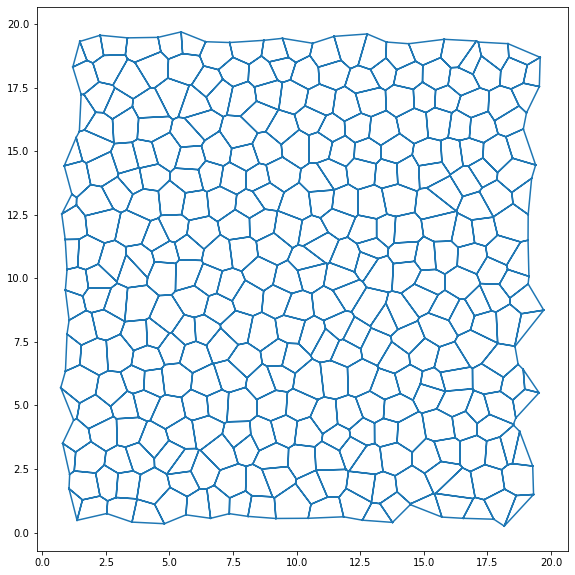

In [12]:
## Definition of the sheet

cellmap_original = Sheet.planar_sheet_2d('cellmap', 30, 30, 1, 1, noise = 0.2) # This may need to change
geom_original  = PlanarGeometry

to_cut = cellmap_original.cut_out([(0, 20), (0, 20)])
cellmap_original.remove(to_cut, trim_borders=True)

cellmap_original.sanitize(trim_borders = True)
geom.update_all(cellmap_original)
cellmap_original.update_rank()

model_original = model_factory([    
    effectors.FaceAreaElasticity,
    effectors.LengthElasticity
    ])

history_original = History(cellmap_original,
                           extra_cols={"edge":["dx", "dy"]})

cellmap_original.update_specs(model_original.specs)

fig, ax = sheet_view(cellmap_original, ['x', 'y'], mode='quick')
fig.set_size_inches(10, 10)

In [13]:
cellmap_original.face_df

,y,is_alive,perimeter,area,x,num_sides,id,area_elasticity,prefered_area
face,,,,,,,,,
0,1.169295,1,2.807451,0.259986,1.331984,3,0,1.0,1.0
1,1.043683,1,3.588693,0.775965,2.063606,5,0,1.0,1.0
2,1.074347,1,3.661286,0.838231,3.162537,6,0,1.0,1.0
3,0.800412,1,3.771593,0.805734,4.116839,4,0,1.0,1.0
4,1.073573,1,4.157758,1.177579,5.116505,5,0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
348,18.841024,1,3.973657,0.947592,15.100193,5,0,1.0,1.0
349,18.795056,1,4.106532,1.009545,16.186943,5,0,1.0,1.0
350,18.735916,1,3.343925,0.585487,16.948241,5,0,1.0,1.0


In [14]:
history_original

## Phase: Homeostasis

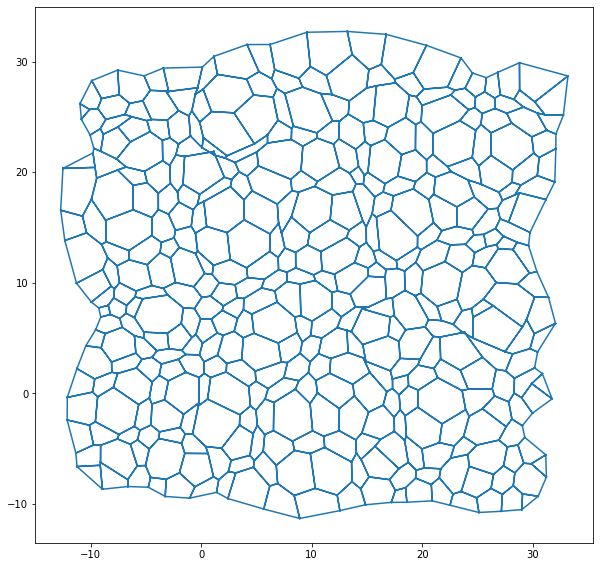

In [34]:
[cellmap_H, geom_H, model_H, history_H] = change_specs(cellmap_original, geom_original, model_original, history_original, area_elasticity = 0.5, lower_prefered_area = 100, higher_prefered_area = 10000, 
                                                       FRC_lower_length_elasticity = 1000, FRC_higher_length_elasticity = 10000, ECM_lower_length_elasticity = 10, 
                                                       ECM_higher_length_elasticity = 1000, line_nought = 0.1)

In [39]:
cellmap_H.face_df["area"].mean()

4.8591836350524655

In [41]:
cellmap_H.edge_df["length_elasticity"].max()

1.0973

Text(0, 0.5, 'Frequency area')

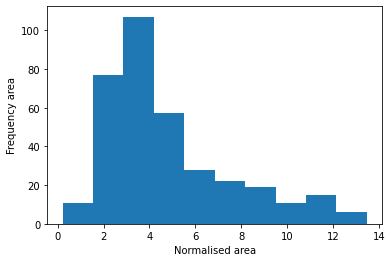

In [17]:
plt.hist(area, bins = 10)
plt.xlabel('Normalised area')
plt.ylabel('Frequency area')


In [18]:
normalised_Area = cellmap_H.face_df["area"]/max(cellmap_H.face_df["area"])

In [19]:
normalised_Area

face
0      0.031060
1      0.146311
2      0.343303
3      0.573979
4      0.930469
         ...   
348    0.287848
349    0.398005
350    0.222253
351    0.196104
352    0.811143
Name: area, Length: 353, dtype: float64

In [ ]:
plt.hist(normalised_Area, bins = 20)
plt.xlabel('Normalised area')
plt.ylabel('Frequency area')

In [ ]:
fig, ax = sheet_view(cellmap_H, mode="quick")
fig.set_size_inches(10, 10)
fig.
plt.savefig('cellmap_homeostasis.png')

In [ ]:
history_H.face_h[["area","time"]]

In [ ]:
for i, sheet in history_H:
    print(f"mean area at {i}: {sheet.face_df.area.mean():.3f}", )

In [ ]:
type(history_H.retrieve(5))

In [30]:
cellmap_H.face_df["area"].mean()

5.094620532323028

In [ ]:
number_of_faces = len(cellmap_H.face_df)
mean_area_H = cellmap_H.face_df["area"].mean()
total_area_H = number_of_faces*mean_area_H
total_area_H

In [ ]:
history_H.face_h.loc[history_H.face_h['face'] == 1]

In [ ]:
cellmap_H.edge_df["length_elasticity_ECM"]

In [ ]:
cellmap_H.edge_df["length_elasticity"]

In [ ]:
#fig, ax = sheet_view(cellmap_H, ['x', 'y'])
#fig.set_size_inches(15, 15)

#for face, data in cellmap_original.face_df.iterrows():
#    ax.text(data.y, data.x, face, fontsize=7, color="r")

In [ ]:
#create_frames(history_H, '.', 'homeostasis', num_frames=100)

In [23]:
mean_area_H = cellmap_H.face_df["area"].mean()
mean_area_H

17.037197303366987

In [31]:
cellmap_H.vert_df

,y,is_active,x,rank,viscosity
vert,,,,,
0,14.787287,1,12.174898,3,1
1,16.999373,1,20.359220,3,1
2,18.013095,1,15.082977,3,1
3,13.756351,1,0.847053,3,1
4,15.045235,1,0.196068,3,1
...,...,...,...,...,...
699,27.180333,1,-5.522529,3,1
700,28.474624,1,-6.775530,3,1
701,29.792926,1,-5.054137,3,1


## Phase: Expansion

In [42]:
endTime = 20

current_prefered_area = cellmap_H.face_df['prefered_area']
cellmap_H.update_specs(
{"face": {"prefered_area": 3*current_prefered_area}},
reset=True)

current_FRC_length_elasticity = cellmap_H.edge_df['length_elasticity_FRC']
cellmap_H.update_specs(
{"edge": {"length_elasticity_FRC": 0.1*current_FRC_length_elasticity}},
reset=True)

current_line_nought = cellmap_H.edge_df['prefered_length']
cellmap_H.update_specs(
{"edge": {"prefered_length": 1.4*current_line_nought}},
reset=True)

new_verts = np.empty((0, 3))

for numEdge in range(len(cellmap_H.edge_df)):
    currentEdge = cellmap_H.edge_df.loc[numEdge];
    if currentEdge['length_elasticity']>0.95:
        new_vert = add_vert(cellmap_H, numEdge)
        new_verts = np.append(new_verts, [new_vert])
    solver = QSSolver()
    res = solver.find_energy_min(cellmap_H, geom_H, model_H)


    
#new_verts = np.empty((0, 3))
#for numEdge in range(len(cellmap_H.edge_df)):
#    currentEdge = cellmap_H.edge_df.loc[numEdge];
#    if currentEdge['length']>2:
#        new_vert = add_vert(cellmap_H, numEdge)
#        new_verts = np.append(new_verts, [new_vert])
#        
#        for i in range(endTime):
#            solver = QSSolver()
#            res = solver.find_energy_min(cellmap_H, geom_H, model_H, options={"ftol": 1e-2})
#            geom_H.update_all(cellmap_H)
#            history_H.record(time_stamp = i)

geom_H.update_all(cellmap_H)
        

    
    
cellmap_E = copy.deepcopy(cellmap_H)
geom_E = copy.deepcopy(geom_H)
model_E = copy.deepcopy(model_H)
history_E = copy.deepcopy(history_H)




Reseting column prefered_area of the face dataset with new specs
Reseting column length_elasticity_FRC of the edge dataset with new specs
Reseting column prefered_length of the edge dataset with new specs


In [48]:
cellmap_E.vert_df

,y,is_active,x,rank,viscosity
0,21.431451,1,18.351059,3,1
1,23.609440,1,29.660105,3,1
2,24.860635,1,20.198908,3,1
3,12.786974,1,-6.231127,3,1
4,17.841440,1,-9.775403,3,1
...,...,...,...,...,...
930,35.177049,1,-28.579965,3,1
931,5.052881,1,51.472613,3,1
932,47.798649,1,-7.441278,3,1
933,-13.144317,1,50.372302,3,1


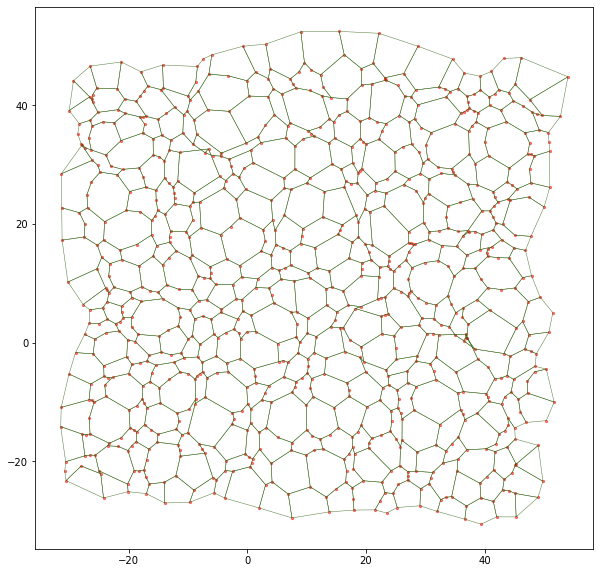

In [43]:
draw_specs = tyssue.config.draw.sheet_spec()

draw_specs['vert']['visible'] = True

draw_specs['vert']['color'] = "red"
draw_specs['vert']['alpha'] = 0.5
draw_specs['vert']['s'] = 5
coords = ['x', 'y']
fig, ax = sheet_view(cellmap_E, coords, **draw_specs)
fig.set_size_inches((10, 10))

In [37]:
cellmap_E.edge_df["length"].nlargest(10)

edge
1986    11.054418
2004     9.615949
30       9.104221
31       9.104221
2029     8.944852
1995     8.276487
2033     8.226153
1190     8.210755
599      8.019182
600      8.019182
Name: length, dtype: float64

In [38]:
cellmap_E.edge_df["length_elasticity_FRC"]

edge
0       0.08652
1       0.05790
2       0.04153
3       0.06923
4       0.09438
         ...   
2034    0.02119
2035    0.06806
2036    0.01523
2037    0.08640
2038    0.09682
Name: length_elasticity_FRC, Length: 2039, dtype: float64

18.145187120336853


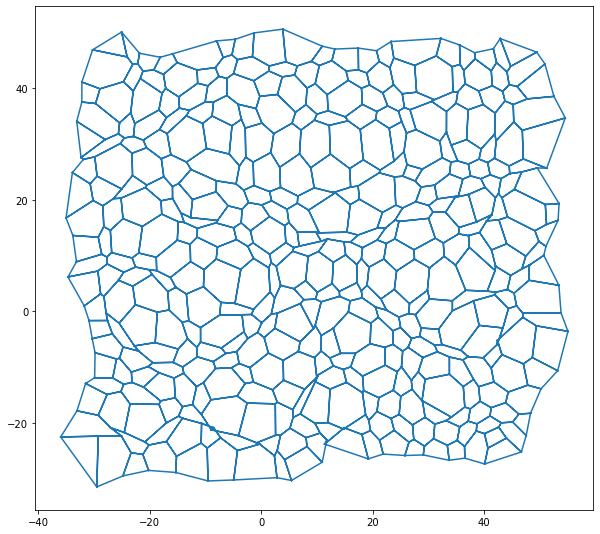

In [39]:
fig, ax = sheet_view(cellmap_E, mode="quick")
fig.set_size_inches(10, 10)

print(cellmap_E.face_df["area"].mean())
#plt.savefig('cellmap_uniform_expansion.png')

In [ ]:
number_of_faces_E = len(cellmap_E.face_df)
mean_area_E = cellmap_E.face_df["area"].mean()
total_area_E = number_of_faces_E*mean_area_E
total_area_E

In [ ]:
cellmap_E.face_df

In [ ]:
#fig, ax = sheet_view(cellmap_E, ['x', 'y'])
#fig.set_size_inches(10, 10)

#for face, data in cellmap_E.face_df.iterrows():
#    ax.text(data.y, data.x, face, fontsize=7, color="r")

In [ ]:
#fig, ax = sheet_view(cellmap_E, ['x', 'y'])
#fig.set_size_inches(10, 10)

## Phase: T cell proliferation

In [ ]:
# Make 40 of A_alphas grow a lot 

In [ ]:
#choosing random 10 of Aalphas:

endTime = 10

ten_random_faces = cellmap_E.face_df.sample(10)
current_prefered_area = ten_random_faces["prefered_area"]
print(current_prefered_area)
ten_random_faces["prefered_area"]= 2.5*current_prefered_area
cellmap_E.face_df.loc[ten_random_faces.index, "prefered_area"] = ten_random_faces
geom_E.update_all(cellmap_E)

print(ten_random_faces["prefered_area"])

#geom.update_all(cellmap_E)

new_verts = np.empty((0, 3))
for numEdge in range(len(cellmap_E.edge_df)):
    currentEdge = cellmap_E.edge_df.loc[numEdge];
    if currentEdge['length']>2:
        new_vert = add_vert(cellmap_E, numEdge)
        new_verts = np.append(new_verts, [new_vert])
    solver_T = QSSolver()
    res_T = solver_T.find_energy_min(cellmap_E, geom_E, model_E)

#for i in range(endTime):
#    solver1 = QSSolver(with_collisions=False, with_t1=False, with_t3=False)
#    res1 = solver1.find_energy_min(cellmap_H, geom_H, model_H, options={"ftol": 1e-2})
#    geom_H.update_all(cellmap_H)
#    history_H.record(time_stamp = i)

cellmap_T = cellmap_E
geom_T = geom_E
model_T = model_E
history_T = history_E

In [ ]:
fig, ax = sheet_view(cellmap_T, mode="quick")

fig.set_size_inches(10, 10)
cellmap_T.face_df['area'].mean()
#plt.savefig('cellmap_T_cell_expansion.png')

In [ ]:
cellmap_T.edge_df['length'].nlargest(10)


In [ ]:
draw_specs = tyssue.config.draw.sheet_spec()

draw_specs['vert']['visible'] = True

draw_specs['vert']['color'] = "red"
draw_specs['vert']['alpha'] = 0.5
draw_specs['vert']['s'] = 5
coords = ['x', 'y']
fig, ax = sheet_view(cellmap_T, coords, **draw_specs)
fig.set_size_inches((10, 10))

In [ ]:
cellmap_T.edge_df["length"].nlargest(10)

In [ ]:
cellmap_T.face_df

In [ ]:
fig, ax = sheet_view(cellmap_T, ['x', 'y'])
fig.set_size_inches(12, 12)

for face, data in cellmap_T.face_df.iterrows():
    ax.text(data.x, data.y, face, fontsize=7, color="r")

In [ ]:
draw_specs['edge']['width'] = 1
color = cellmap_T.edge_df['length']
color[color<0] = 0;
ipv.clear()
fig2, mesh = sheet_view(cellmap_T, edge={"color":color, "width":1.5}, mode="2D")
fig2.set_size_inches(10, 10)



#plt.savefig('length_colour_T.png')

## Phase: V new vertices 

In [ ]:
#forty_percent = round(0.4*len(cellmap_T.edge_df['length']))
#longest_forty_percent = cellmap_T.edge_df['length'].nlargest(n=forty_percent)
#edge_lim = longest_forty_percent.nsmallest(n=1)

In [ ]:
#edge_lim

In [ ]:
new_verts = np.empty((0, 3))
for numEdge in range(len(cellmap_T.edge_df)):
    currentEdge = cellmap_T.edge_df.loc[numEdge];
    if currentEdge['length']>2:
        new_vert = add_vert(cellmap_T, numEdge)
        new_verts = np.append(new_verts, [new_vert])
    

In [ ]:
len(new_verts)

In [ ]:
draw_specs = tyssue.config.draw.sheet_spec()

draw_specs['vert']['visible'] = True

draw_specs['vert']['color'] = "red"
draw_specs['vert']['alpha'] = 0.5
draw_specs['vert']['s'] = 5


coords = ['x', 'y']
fig, ax = sheet_view(cellmap_T, coords, **draw_specs)
fig.set_size_inches((12, 12))

In [ ]:
fig, ax = sheet_view(cellmap_T, ['x', 'y'])
fig.set_size_inches(12, 12)
for face, data in cellmap_T.face_df.iterrows():
    ax.text(data.x, data.y, face, fontsize=7, color="r")

In [ ]:
ten_random_faces.index

### Phase D: cell division

In [ ]:
ten_random_faces['prefered_area']

In [ ]:
eighty_percent = round(0.4*len(cellmap_T.face_df['area']))
print(eighty_percent)
longest_eighty_percent = cellmap_T.face_df['area'].nlargest(n=eighty_percent)
longest_eighty_percent

In [ ]:
### divide T prolif areas and % of largest areas of your choice


#for numFace in range(len(cellmap_T.face_df)):
#    if numFace in ten_random_faces.index or numFace in longest_eighty_percent:
#        #print(numFace)
#        mother = numFace
#        daughter = cell_division(cellmap_T, mother, geom_T, angle=np.pi/2)
#        cellmap_T.face_df.loc[numFace, "prefered_area"] /= 2
#        cellmap_T.face_df.loc [daughter, "prefered_area"] /= 2
#        
#        solver = QSSolver()
#        res = solver.find_energy_min(cellmap_T, geom_T, model_T)
#        
#        print(res['success'])
        



        

#cellmap_D = cellmap_T
#geom_D = geom_T
#model_D = model_T
#history_D = history_T

#fig, ax = sheet_view(cellmap_D)
#fig.set_size_inches(12, 12)

In [ ]:
### divide all T cell areas

for numFace in range(len(cellmap_T.face_df)):
    mother = numFace
    daughter = cell_division(cellmap_T, mother, geom_T, angle=np.pi/2)
    if numFace in ten_random_faces:
        cellmap_T.face_df.loc[numFace, "prefered_area"] /= 4
        cellmap_T.face_df.loc [daughter, "prefered_area"] /= 4
    else:
        cellmap_T.face_df.loc[numFace, "prefered_area"] /= 2
        cellmap_T.face_df.loc [daughter, "prefered_area"] /= 2
    
        
    solver = QSSolver()
    res = solver.find_energy_min(cellmap_T, geom_T, model_T)
        
    #print(res['success'])
        



        

cellmap_D = cellmap_T
geom_D = geom_T
model_D = model_T
history_D = history_T

fig, ax = sheet_view(cellmap_D)
fig.set_size_inches(12, 12)

In [ ]:
for numFace in range(len(cellmap_T.face_df)):
    if numFace in ten_random_faces.index or numFace in longest_eighty_percent:
        #print(numFace)
        mother = numFace
        daughter = cell_division(cellmap_T, mother, geom_T, angle=np.pi/2)
        cellmap_T.face_df.loc[numFace, "prefered_area"] /= 2
        cellmap_T.face_df.loc [daughter, "prefered_area"] /= 2
        
        solver = QSSolver()
        res = solver.find_energy_min(cellmap_T, geom_T, model_T)
        
        print(res['success'])
        



        

cellmap_D = cellmap_T
geom_D = geom_T
model_D = model_T
history_D = history_T

fig, ax = sheet_view(cellmap_D)
fig.set_size_inches(12, 12)

In [ ]:
fig, ax = sheet_view(cellmap_D, mode="quick")

fig.set_size_inches(10, 10)
cellmap_D.face_df['area'].mean()
#plt.savefig('cellmap_T_cell_expansion.png')

In [ ]:
cellmap_D.face_df['area'].mean()

In [ ]:
len(cellmap_D.face_df)*cellmap_D.face_df['area'].mean()

In [ ]:
fig, ax = sheet_view(cellmap_D, ['x', 'y'])
fig.set_size_inches(12, 12)

for face, data in cellmap_D.face_df.iterrows():
    ax.text(data.x, data.y, face, fontsize=7, color="r")

In [ ]:
#fig, ax = sheet_view(cellmap_T)
#fig.set_size_inches(15, 15)


#for edge, data in cellmap_T.edge_df.iterrows():
#    ax.text((data.sx+data.tx)/2, (data.sy + data.ty)/2, edge, color="blue")